# Demonstrating `stats` module

In this notebook we show the how to use and apply the classess and method in the `stats` module this include:
- Importing, selecting and changing probability distribution information of uncertain parameters
- global sensitivity analysis (GSA)
- Chance constraint optimization

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../develop_test')
import stats as pulpostats
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Defining the case

The case for which the sensitivity analysis will be performed for is on a solution of the LP:

$$
    \begin{align}
        & \underset{s, slack}{\text{min}}  && z_h \\
        & \text{s.t.}   && \sum_{j}(a_{i,j}\cdot s_j) = f_i && \forall i \\
        &               && s_j^{low} \leq s_j \leq s_j^{high} && \forall j \\
        &               && z_h = \sum_e \sum_j (q_{h,e}\cdot b_{e,j} \cdot s_j) && \forall h \\
    \end{align}
$$


### 1.1. Rice husk problem


In [ ]:
case_study = pulpostats.RiceHuskCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name="rice_husc_test")


### 1.2. Defining the electricity showcase problem

In [ ]:
case_study = pulpostats.ElectricityCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='electricity_test')

### 1.3. Defining the Ammonia case study

In [3]:
case_study = pulpostats.AmmoniaCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='ammonia_test')


Creating Instance
Instance created
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47103 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47103 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23538 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23549 upper bounds greater than or equal to        1e+20 are treated as +Infinity
optimal solution found:  4030847092.3789687


## Total Impact(s)

,Weight,Value
Method,,
"('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')",1,4.030847e+09


## Choices Made

### ammonia

,Value,Capacity
Metadata,,
"ammonia production, from nitrogen and hydrogen | ammonia production, from nitrogen and hydrogen | RER",2.010082e+09,1.000000e+20


### methane_market

,Value,Capacity
Metadata,,
"market group for natural gas, high pressure | natural gas, high pressure | Europe without Switzerland",2.183657e+09,1.000000e+20
market for bio methane | methane | RER,2.092156e+08,1.000000e+20


### hydrogen_market

,Value,Capacity
Metadata,,
market for hydrogen | hydrogen | RER,3.537744e+08,1.000000e+20


### ammonia_market

,Value,Capacity
Metadata,,
market for ammonia | ammonia | RER,3.000122e+09,1.000000e+20


### hydrogen

,Value,Capacity
Metadata,,
"hydrogen production, steam methane reforming fg | hydrogen production, biomethane | RER",2.034744e+08,1.000000e+20
"hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER",1.500000e+08,1.500000e+08
"hydrogen production, plastics gasification, w/ CCS | hydrogen production, plastics gasification, with CCS | RER",3.000000e+05,3.000000e+05


### heat

,Value,Capacity
Metadata,,
heat from methane | heat from methane | RER,7.854797e+09,1.000000e+20
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER",1.400000e+09,1.400000e+09


### biomethane

,Value,Capacity
Metadata,,
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER",1.351234e+08,1.000000e+20
"biogas upgrading to biomethane, chemical scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.600000e+07
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.600000e+07


## Constraints

### Constraints Upper

,Key,Metadata,Value,Limit
ID,,,,
23532,"(ammonia-reduced, a2610a42cd93afb46b13b2e95273...","anaerobic digestion of animal manure, with bio...",360000000.0,360000000.0


## 2. Filtering out negletable uncertain parameters

**Reformulating the problem for the sensitivity analysis**

We only consider uncertainty in the $B$ and $Q$ parameter matrizes. The scaling vector is given by the optimal solution.

We will look at the environmental impact objective:

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

In [4]:
paramfilter = pulpostats.ParameterFilter(
    result_data=result_data, 
    lci_data=case_study.pulpo_worker.lci_data, 
    choices = case_study.choices,
    demand = case_study.demand,
    method = case_study.method
    )

Using the basic scaling vector which only includes the optimal choices in the scaling vector

In [5]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='naive')

Using the scaling vector constructed from all choices

In [6]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='constructed_demand')

Compute the LCA scores and return the characterized inventory to be used for the filtering

In [7]:
lca_score, characterized_inventory = paramfilter.compute_LCI_LCIA(scaling_vector_series)

chosen environmental impact method: ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
The total impact is: 4.395060e+01


Plot the largest contributors

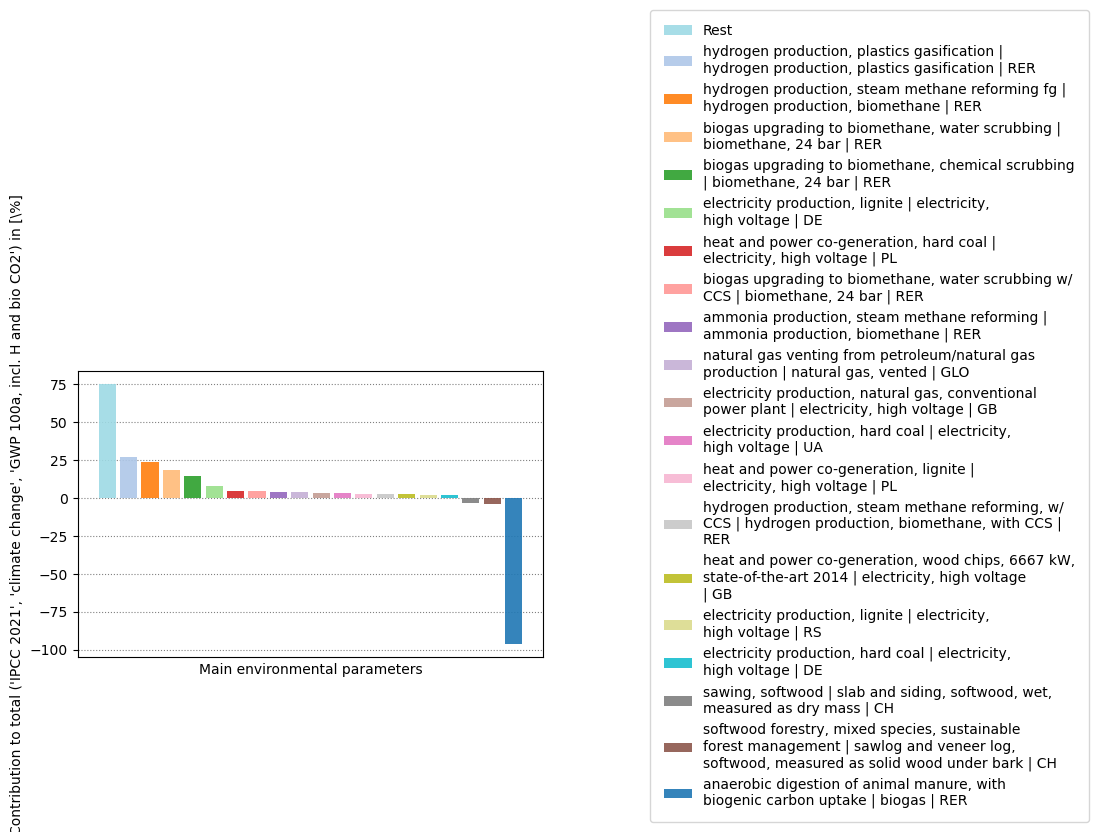

In [8]:
paramfilter.plot_top_processes(characterized_inventory, top_amount=19)

Filtering out the inventoryflows $B_{i,j}$ that have a neglectable impact

In [9]:
cutoff = 0.#0.000019
filtered_inventory_indcs = paramfilter.filter_inventoryflows(characterized_inventory, lca_score, cutoff)

Characterized inventory: (2648, 23557) 26580
Filtered characterized inventory: (2648, 23557) 26580
Deviation from LCA score: 0.0
inventory (2648, 23557) filtering resulted in 26580 of 26580 exchanges (100.0% of total impact) and took 0.006 seconds.


In [10]:
filtered_characterization_indcs = paramfilter.filter_characterization_factors(filtered_inventory_indcs)

CHARACTERIZATION MATRIX (2648,) filtering resulted in 99 of 111 characterization factors


## 3. Getting the uncertainty of the parameter values

### 3.1. Interventions flows

Extract the metadata containing the uncertainty information to the filtered intervention flows and seperate the metadata into the parameters with and without defined uncertainty information

In [11]:
uncertainty_importer = pulpostats.UncertaintyImporter(lci_data=case_study.pulpo_worker.lci_data)
backgroundDB_filtInv_indcs = uncertainty_importer.get_intervention_indcs_to_db('ecoinvent-3.10-cutoff', filtered_inventory_indcs)
foregroundDB_filtInv_indcs = uncertainty_importer.get_intervention_indcs_to_db('ammonia-reduced', filtered_inventory_indcs)
bg_inventory_metadata_df = uncertainty_importer.get_intervention_meta(inventory_indices=backgroundDB_filtInv_indcs)
fg_inventory_metadata_df = uncertainty_importer.get_intervention_meta(inventory_indices=foregroundDB_filtInv_indcs)
bg_inventory_defined,  bg_inventory_undefined = uncertainty_importer.separate(bg_inventory_metadata_df)
fg_inventory_defined,  fg_inventory_undefined = uncertainty_importer.separate(fg_inventory_metadata_df)


Parameters with uncertainty information: 19896 
Parameters without uncertainty information: 6633
Parameters with uncertainty information: 0 
Parameters without uncertainty information: 51


Apply the triangular strategy using bound interpolation to the missing intervention uncertainty parameters in the background database

upper spread statistics
mean: 1.9300
mode: 0    3.466758
dtype: float64
median: 0.9529
std: 7.4745
min: 0.0287
max: 786.9859


lower spread statistics
mean: 0.6154
mode: 0    0.776124
dtype: float64
median: 0.4879
std: 7.2180
min: 0.0279
max: 786.9859

The upper spread scaling factor for intervention flows is: 0.9529236746994976
The lower spread scaling factor for intervention flows is: 0.4879472130749054


/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0016734681526411272' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_fac * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0004427614504752935' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_fac * abs(amount)


uncertain parameters with negative median value:
            input  output  type  uncertainty_type      amount         loc  \
row  col                                                                    
81   4195     108    8558     2                 5   -2.016300   -2.016300   
     10769    108   15132     2                 5   -7.208600   -7.208600   
     12206    108   16569     2                 5   -2.016300   -2.016300   
     15234    108   19597     2                 5   -7.208600   -7.208600   
718  1667    1034    6030     2                 5   -0.001100   -0.001100   
...           ...     ...   ...               ...         ...         ...   
2129 23088   3721   27451     2                 5 -669.673340 -669.673340   
     23258   3721   27621     2                 5   -0.000997   -0.000997   
     23497   3721   27860     2                 5   -0.429330   -0.429330   
     23498   3721   27861     2                 5   -0.021967   -0.021967   
     23512   3721   27875  

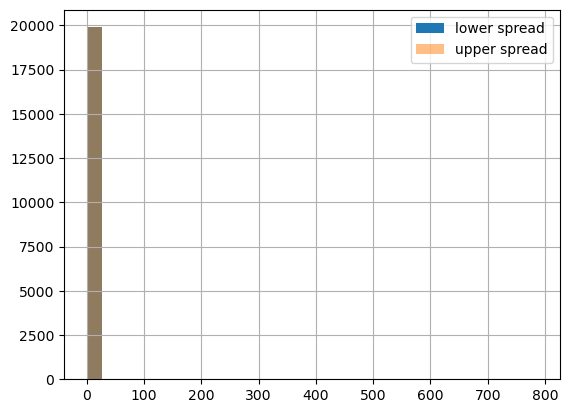

In [12]:
if_bg_triangular_strategy = pulpostats.TriangularBoundInterpolationStrategy(
    metadata_df=bg_inventory_metadata_df,
    undefined_uncertainty_indices= bg_inventory_undefined,
    defined_uncertainty_metadata=bg_inventory_defined,
    noise_interval={'min':.1, 'max':.1}
    )

Apply the Uniform strategy for the uncertainty parameters in the foreground database

In [13]:
if_fg_uniform_strategy = pulpostats.UniformBaseStrategy(
    metadata_df=fg_inventory_metadata_df,
    undefined_uncertainty_indices=fg_inventory_undefined,
    upper_scaling_factor = .5,
    lower_scaling_factor = .5,
    noise_interval={'min':.2, 'max':.2}
)

/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1079: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1006371710554484e-06' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_factor * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1080: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.7304699386554805e-07' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_factor * abs(amount)


In [16]:
if_fg_uniform_strategy.rename_metadata_index(case_study.pulpo_worker.lci_data, 'intervention_flow')


,row,col,input,output,type,uncertainty_type,amount,loc,scale,shape,minimum,maximum,negative
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Butane | ('air', 'urban air close to ground')",68,23552,92,28132,2,4,7.368421e-07,NaN,NaN,NaN,3.730470e-07,1.100637e-06,False
"heat from methane | heat from methane | RER --- Butane | ('air', 'urban air close to ground')",68,23556,92,28189,2,4,7.368421e-07,NaN,NaN,NaN,3.355174e-07,1.138167e-06,False
"transport, pipeline, supercritical carbon dioxide, 200 km without recompression | transport, pipeline, supercritical carbon dioxide, 200 km without recompression | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')",80,23538,107,28117,2,4,2.600000e-04,NaN,NaN,NaN,1.436348e-04,3.763652e-04,False
"carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')",80,23548,107,28128,2,4,1.000000e-02,NaN,NaN,NaN,5.477705e-03,1.452229e-02,False
"anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER --- Carbon dioxide, in air | ('natural resource', 'in air')",81,23532,108,28111,2,4,2.444555e+00,NaN,NaN,NaN,1.179478e+00,3.709632e+00,False
"ammonia production, steam methane reforming | ammonia production, biomethane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23524,109,28103,2,4,1.432585e+00,NaN,NaN,NaN,8.099505e-01,2.055219e+00,False
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23552,109,28132,2,4,5.894737e-03,NaN,NaN,NaN,2.603073e-03,9.186401e-03,False
"ammonia production, steam methane reforming, w/ CCS | ammonia production, biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23553,109,28133,2,4,4.870788e-03,NaN,NaN,NaN,2.685841e-03,7.055734e-03,False
"heat from methane | heat from methane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23556,109,28189,2,4,5.894737e-02,NaN,NaN,NaN,2.994749e-02,8.794725e-02,False
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Carbon monoxide, non-fossil | ('air', 'urban air close to ground')",85,23552,112,28132,2,4,2.210526e-06,NaN,NaN,NaN,1.088211e-06,3.332841e-06,False


Set expert judgement uncertainties to a few selected intervention flows:

In [26]:
CCS_expert_uncertainty_info = {
    (80, 23548): {'minimum':.01 ,'maximum':.5, 'uncertainty_type':4}, # carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')
    (80, 23538): {'minimum':.0002 ,'maximum':.002, 'uncertainty_type':4}, # transport, pipeline, supercritical carbon dioxide, 200 km without recompression | transport, pipeline, supercritical carbon dioxide, 200 km without recompression | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')
    }
if_fg_expert_knowledge_strategy = pulpostats.ExpertKnowledgeStrategy(
    if_fg_uniform_strategy.metadata_assigned_df,
    CCS_expert_uncertainty_info.keys(),
    CCS_expert_uncertainty_info
)

Check if the uncertainty data has been assgined correctly to the flows

In [27]:
if_fg_expert_knowledge_strategy.rename_metadata_index(case_study.pulpo_worker.lci_data, 'intervention_flow')

,row,col,input,output,type,uncertainty_type,amount,loc,scale,shape,minimum,maximum,negative
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Butane | ('air', 'urban air close to ground')",68,23552,92,28132,2,4,7.368421e-07,NaN,NaN,NaN,3.730470e-07,1.100637e-06,False
"heat from methane | heat from methane | RER --- Butane | ('air', 'urban air close to ground')",68,23556,92,28189,2,4,7.368421e-07,NaN,NaN,NaN,3.355174e-07,1.138167e-06,False
"transport, pipeline, supercritical carbon dioxide, 200 km without recompression | transport, pipeline, supercritical carbon dioxide, 200 km without recompression | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')",80,23538,107,28117,2,4,2.600000e-04,NaN,NaN,NaN,2.000000e-04,2.000000e-03,False
"carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')",80,23548,107,28128,2,4,1.000000e-02,NaN,NaN,NaN,1.000000e-02,5.000000e-01,False
"anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER --- Carbon dioxide, in air | ('natural resource', 'in air')",81,23532,108,28111,2,4,2.444555e+00,NaN,NaN,NaN,1.179478e+00,3.709632e+00,False
"ammonia production, steam methane reforming | ammonia production, biomethane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23524,109,28103,2,4,1.432585e+00,NaN,NaN,NaN,8.099505e-01,2.055219e+00,False
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23552,109,28132,2,4,5.894737e-03,NaN,NaN,NaN,2.603073e-03,9.186401e-03,False
"ammonia production, steam methane reforming, w/ CCS | ammonia production, biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23553,109,28133,2,4,4.870788e-03,NaN,NaN,NaN,2.685841e-03,7.055734e-03,False
"heat from methane | heat from methane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23556,109,28189,2,4,5.894737e-02,NaN,NaN,NaN,2.994749e-02,8.794725e-02,False
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Carbon monoxide, non-fossil | ('air', 'urban air close to ground')",85,23552,112,28132,2,4,2.210526e-06,NaN,NaN,NaN,1.088211e-06,3.332841e-06,False


### 3.2. Characterization factors

Extract the metadata containing the uncertainty information to the filtered characterization factors and seperate the metadata into the parameters with and without defined uncertainty information

In [ ]:
characterization_metadata_df = uncertainty_importer.get_cf_meta(
    characterization_indices=filtered_characterization_indcs,
    method=case_study.method
    )
cf_defined,  cf_undefined = uncertainty_importer.separate(characterization_metadata_df)

Apply the triangular strategy using predefined scaling factors to the missing uncertainty parameters

In [ ]:
upper_scaling_factor_cf = 0.15
lower_scaling_factor_cf = 0.15
cf_triangular_strategy = pulpostats.TriangluarBaseStrategy(
    metadata_df=characterization_metadata_df,
    defined_uncertainty_metadata=cf_defined,
    undefined_uncertainty_indices=cf_undefined,
    upper_scaling_factor = upper_scaling_factor_cf,
    lower_scaling_factor = lower_scaling_factor_cf,
    noise_interval={'min':.1, 'max':.1}
)

In [ ]:
unc_metadata = {
    'cf': cf_triangular_strategy.metadata_assigned_df,
    'if': pd.concat([
        # Takes the 'if_fg_expert_knowledge_strategy' since it contains teh updated metadata from 'if_fg_uniform_strategy'
        if_fg_expert_knowledge_strategy.metadata_assigned_df, 
        if_bg_triangular_strategy.metadata_assigned_df
        ])
}

## 4. Define the global sensitivity problem
### 4.1. Define the bound/interval of the parameters

Check if all parameters have gotten uncertainty information asigned

In [ ]:
from SALib.sample import sobol as sample_method
from SALib.analyze import sobol as SA_method
N = 2**3

gsa = pulpostats.GlobalSensitivityAnalysis(
    result_data=result_data,
    lci_data=case_study.pulpo_worker.lci_data,
    unc_metadata=unc_metadata,
    sampler=sample_method,
    analyser=SA_method,
    sample_size=N,
    method=case_study.method
)
gsa_problem, all_bounds_indx_dict = gsa.define_problem()

In [ ]:
sample_data_if, sample_data_cf = gsa.sample(gsa_problem, all_bounds_indx_dict)

In [ ]:
sample_impacts, sample_characterized_inventories = gsa.run_model(sample_data_if, sample_data_cf)

In [ ]:
total_Si = gsa.analyze(gsa_problem, sample_impacts)

In [ ]:
total_Si_metadata = gsa.generate_Si_metadata(all_bounds_indx_dict, total_Si)
colormap_base, colormap_SA_barplot = gsa.plot_top_total_sensitivity_indices(total_Si, total_Si_metadata)

In [ ]:
data_plot = gsa.plot_total_env_impact_contribution(
    sample_characterized_inventories, 
    total_Si_metadata, 
    colormap_base=colormap_base, 
    colormap_SA_barplot=colormap_SA_barplot,
    )

## 5. CC formulation

Formulate the chance constrain optimization problem. 

In the future multiple formulations might be possible, represented by different `CCFormulation` classes

In [ ]:
cc_formulation = pulpostats.CCFormulationObjIndividualNormalL1(
    unc_metadata=unc_metadata,
    pulpo_worker=case_study.pulpo_worker,
    method=case_study.method,
    choices=case_study.choices,
    demand=case_study.demand
)

Initiate epsilon solver for the Pareto Problem

In [ ]:
epsilon_pareto_solver = pulpostats.EpsilonConstraintSolver(cc_formulation)

Solve single Pareto point

In [ ]:
CC_solution = epsilon_pareto_solver.solve_single_pareto_point(lambda_level=.5)
CC_solution

Solve for an array of lambda epsilon constraints

In [ ]:
lambda_epsilon_array = np.linspace(0.5,1, 5, endpoint=False)
CC_solutions = epsilon_pareto_solver.solve(lambda_epsilon_array)

Plot Pareto front

In [ ]:
epsilon_pareto_solver.plot_pareto_front(CC_solutions, 0.005, bbox_to_anchor=(0.65,-1.8))

Compare the Pareto points

In [ ]:
epsilon_pareto_solver.compare_subsequent_paretosolutions(CC_solutions)

## Pareto front case studies

### More detailled Pareto Front

In [ ]:
lambda_epsilon_array = np.linspace(0.5,1, 20, endpoint=False)
CC_solutions = epsilon_pareto_solver.solve(lambda_epsilon_array)
epsilon_pareto_solver.plot_pareto_front(CC_solutions, 0.005, bbox_to_anchor=(0.65,-1.8))
epsilon_pareto_solver.compare_subsequent_paretosolutions(CC_solutions)